# **RISK PROFILING ACCORDING TO INVESTOR RISK TOLERANCE**

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Running strategy for high_risk profile:


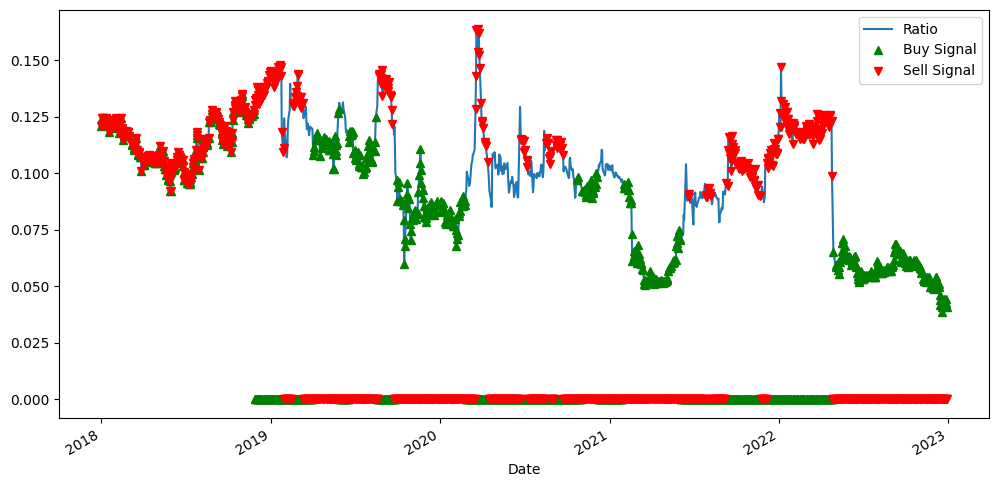

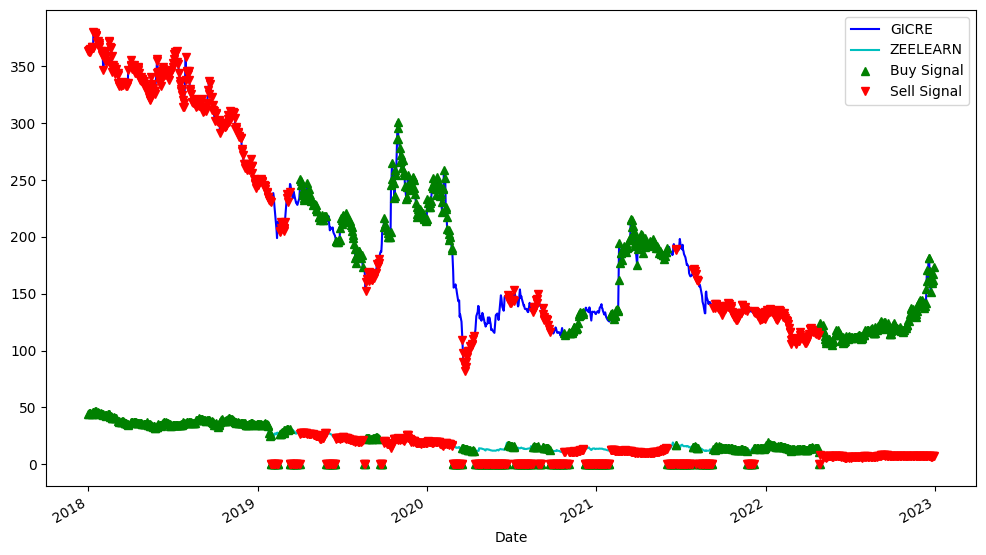

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Profitability: Profit percentage: 277.83%
Risk adjusted returns: Sharpe Ratio: 1.70
Consistency: Standard Deviation: 5.55
Running strategy for mid_risk profile:


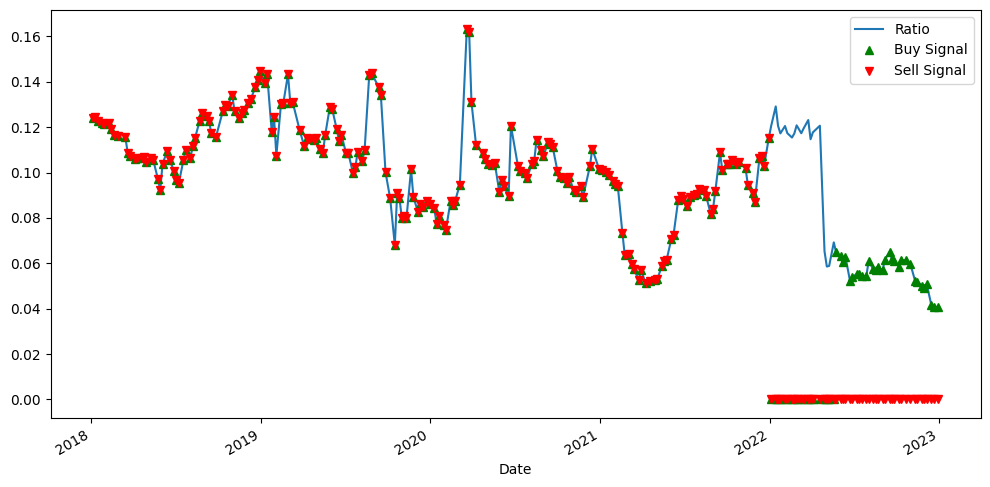

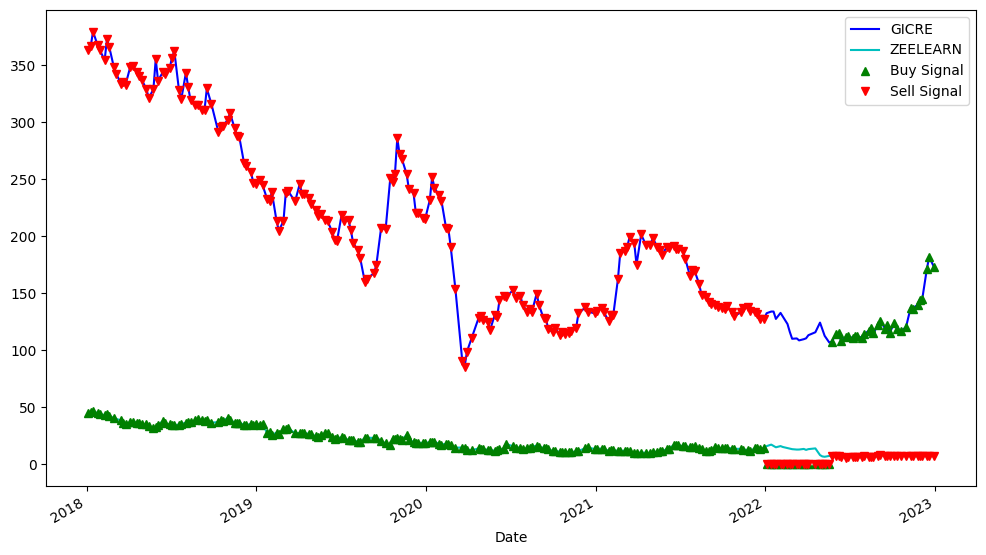

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Profitability: Profit percentage: 35.14%
Risk adjusted returns: Sharpe Ratio: 2.90
Consistency: Standard Deviation: 5.31
Running strategy for low_risk profile:


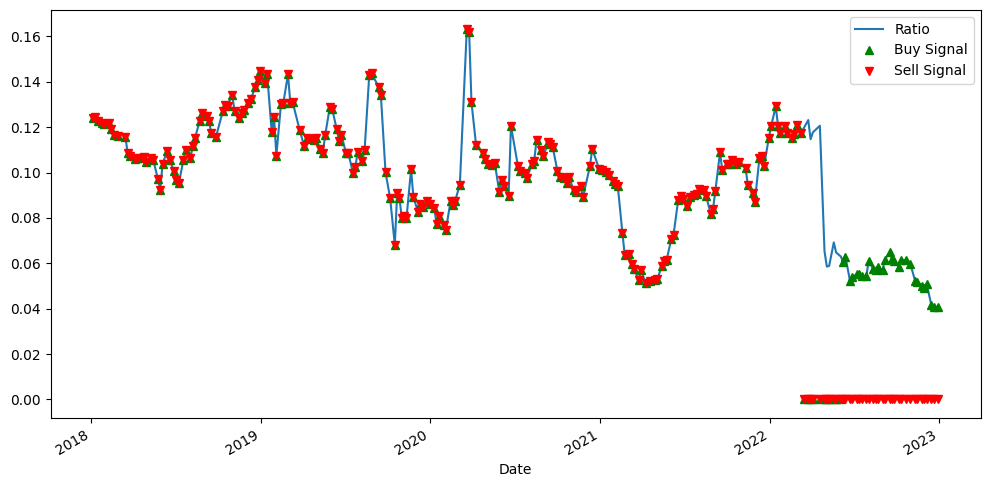

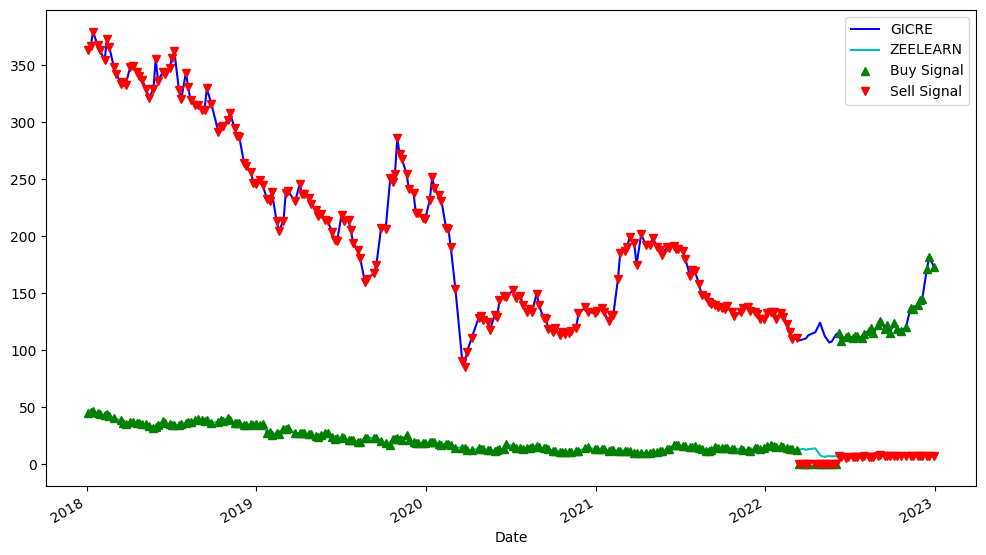

Profitability: Profit percentage: 33.07%
Risk adjusted returns: Sharpe Ratio: 3.34
Consistency: Standard Deviation: 4.77


In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def trade_strategy_freq(start, end, window1, window2, frequency, zscore_threshold):

    intervals = {
        '1d': '1d',
        '1wk': '1wk',
        '5d': '5d',
    }
    
    if frequency not in intervals:
        raise ValueError("Frequency must be one of: '1d', '1wk', '5d'")

    gicre_data = yf.download('GICRE.BO', start=start, end=end, interval=intervals[frequency])
    zeelearn_data = yf.download('ZEELEARN.BO', start=start, end=end, interval=intervals[frequency])
    
    sensex_data = yf.download('^BSESN', start, end)
    nifty_data = yf.download('^NSEI', start, end)

    gicre_prices = gicre_data['Adj Close']
    zeelearn_prices = zeelearn_data['Adj Close']
    sensex_prices = sensex_data['Adj Close']
    nifty_prices = nifty_data['Adj Close']

    ratio = zeelearn_prices / gicre_prices

    ratio_mavg1 = ratio.rolling(window=window1).mean()
    ratio_mavg2 = ratio.rolling(window=window2).mean()
    std_2 = ratio.rolling(window=window2).std()
    zscore = (ratio_mavg1 - ratio_mavg2) / std_2

    plt.figure(figsize=(12, 6))
    ratio.plot()
    buy = ratio.copy()
    sell = ratio.copy()
    buy[zscore > -zscore_threshold] = 0
    sell[zscore < zscore_threshold] = 0
    buy.plot(color='g', linestyle='None', marker='^')
    sell.plot(color='r', linestyle='None', marker='v')
    plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
    plt.show()

    plt.figure(figsize=(12, 7))
    gicre_prices.plot(color='b')
    zeelearn_prices.plot(color='c')

    buyR = pd.Series(0, index=gicre_prices.index)
    sellR = pd.Series(0, index=gicre_prices.index)

    buyR[buy != 0] = gicre_prices[buy != 0]
    sellR[buy != 0] = zeelearn_prices[buy != 0]

    buyR[sell != 0] = zeelearn_prices[sell != 0]
    sellR[sell != 0] = gicre_prices[sell != 0]

    buyR.plot(color='g', linestyle='None', marker='^')
    sellR.plot(color='r', linestyle='None', marker='v')

    plt.legend(['GICRE', 'ZEELEARN', 'Buy Signal', 'Sell Signal'])
    plt.show()

    def trade(gicre_prices, zeelearn_prices, window1, window2, zscore_threshold):
        if (window1 == 0) or (window2 == 0):
            return 0
        
        ratio = zeelearn_prices / gicre_prices
        ma1 = ratio.rolling(window=window1).mean()
        ma2 = ratio.rolling(window=window2).mean()
        std = ratio.rolling(window=window2).std()
        zscore = (ma1 - ma2) / std
        
        money = 10000
        count_zeelearn = 0
        count_gicre = 0
        returns = []
        
        for i in range(len(ratio)):
            if zscore[i] < -zscore_threshold:
                if i < len(gicre_prices) and i < len(zeelearn_prices):
                    money += gicre_prices[i] - zeelearn_prices[i]
                    count_gicre -= 1
                    count_zeelearn += 1
                    returns.append((gicre_prices[i] - zeelearn_prices[i]) / zeelearn_prices[i])
            elif zscore[i] > zscore_threshold:
                if i < len(gicre_prices) and i < len(zeelearn_prices):
                    money -= gicre_prices[i] - zeelearn_prices[i]
                    count_gicre += 1
                    count_zeelearn -= 1
                    returns.append((gicre_prices[i] - zeelearn_prices[i]) / zeelearn_prices[i])
            elif abs(zscore[i]) < 0.25:
                if i < len(gicre_prices) and i < len(zeelearn_prices):
                    money += gicre_prices[i] * count_gicre + zeelearn_prices[i] * count_zeelearn
                    count_gicre = 0
                    count_zeelearn = 0
                    returns.append(0)
                
        return money, returns

    final, returns = trade(gicre_prices, zeelearn_prices, window1, window2, zscore_threshold)

    profit_percentage = ((final - 10000) / 10000)*100
    print("Profitability: Profit percentage: {:.2f}%".format(profit_percentage))

    returns = np.array(returns)
    monthly_returns = np.mean(returns)
    std_dev = np.std(returns)
    sharpe_ratio = (monthly_returns - 0) / std_dev if std_dev != 0 else 0

    print("Risk adjusted returns: Sharpe Ratio: {:.2f}".format(sharpe_ratio))
    print("Consistency: Standard Deviation: {:.2f}".format(std_dev))
    return profit_percentage, sharpe_ratio, std_dev

risk_profiles = {
    'high_risk': {'frequency': '1d', 'window1': 6, 'window2': 180, 'zscore_threshold': 0.6},
    'mid_risk': {'frequency': '5d', 'window1': 8, 'window2': 190, 'zscore_threshold': 0.8},
    'low_risk': {'frequency': '5d', 'window1': 10, 'window2': 200, 'zscore_threshold': 1.0}
}

for profile_name, params in risk_profiles.items():
    print(f"Running strategy for {profile_name} profile:")
    profit_percentage, sharpe_ratio, std_dev = trade_strategy_freq(start='2018-01-01', end='2023-01-01', 
                                                                   window1=params['window1'], 
                                                                   window2=params['window2'], 
                                                                   frequency=params['frequency'], 
                                                                   zscore_threshold=params['zscore_threshold'])
    
